# Improve land CSEM calculation

## The problem

There exists a numerical singularity in the wavenumber-frequency domain. This singularity is always present, but it is usually neglectible except when the resistivity is very high (like air; hence conductivity goes to zero and therefore the real part of $\eta_H$, $\eta_V$ goes to zero) and source and receiver are close to this boundary. So unfortunately exactly in the case of a land CSEM survey.

This singularity leads to noise at very high frequencies and therefore at very early times because the Hankel transform cannot handle the singularity correctly (or, if you would choose a sufficiently precise quadrature, it would take literally forever to calculate it).

## The "solution"

Electric permittivity ($\varepsilon_H$, $\varepsilon_V$) are set to 1 by default. They are not important for the frequency range of CSEM. By setting the electric permittivity of the air-layer to 0, the singularity disapears, which subsquently improves a lot the time-domain result for land CSEM. It therefore uses the diffusive approximation for the air layer, but again, that doesn't matter for the frequencies required for CSEM.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import empymod as epm

In [2]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

## Define model

In [3]:
# Times (s)
t = np.logspace(-2, 1, 301)

# Model
model = {
    'src': [0, 0, 0.001],           # Source at origin, slightly below interface
    'rec': [6000, 0, 0.0001],       # 6 km offset, in-line, slightly below interface
    'depth': [0, 2000, 2100],       # Target of 100 m at 2 km depth
    'res': [2e14, 10, 100, 10],     # Resistivity: [air, overburden, target, half-space]
    'epermH': [1, 1, 1, 1],         # epermH: corresponds to the default values if not provided
    'epermV': [1, 1, 1, 1],         # epermV: corresponds to the default values if not provided
    'freqtime': t,                  # Times
    'signal': 0,                    # 0: Impulse response
    'ftarg': 'key_81_CosSin_2009',  # We choose a shorter filter then the default one
    'verb': 1,                      # Verbosity; set to 3 to see all parameters in the calculation
}

## Calculate

In [4]:
# Calculate with default eperm_air = 1
res_1 = epm.dipole(**model)

# Set horizontal and vertical electric permittivity of air to 0
model['epermH'][0] = 0
model['epermV'][0] = 0

# Calculate with eperm_air = 0
res_0 = epm.dipole(**model)

## Plot result

As it can be seen, setting $\varepsilon_{air} =$ 0 improves the land CSEM result significantly for earlier times, where the signal should be zero. 

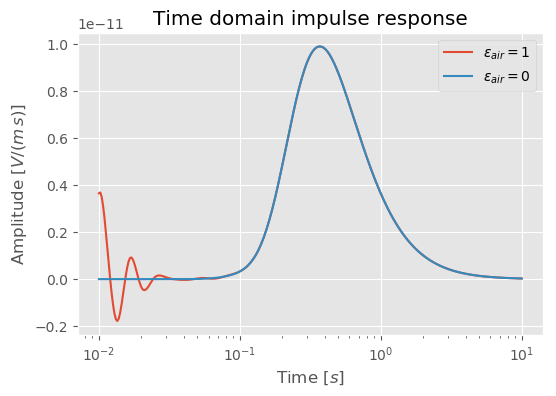

In [5]:
plt.figure()

plt.title('Time domain impulse response')
plt.semilogx(t, res_1, label=r'$\varepsilon_{air}=1$')
plt.semilogx(t, res_0, label=r'$\varepsilon_{air}=0$')
plt.xlabel(r'Time $[s]$')
plt.ylabel(r'Amplitude $[V/(m\,s)]$')
plt.legend()

plt.show()

## Version 1.7.0 and older

If you use a version of `empymod` that is smaller than `1.7.1` and set $\varepsilon_H$, $\varepsilon_V$ to zero you will see the following warning,

    * WARNING :: Parameter epermH < 1e-20  are set to 1e-20 !
    * WARNING :: Parameter epermV < 1e-20  are set to 1e-20 !

and the values will be re-set to the defined minimum value, which is by default 1e-20. Using a value of 1e-20 for `epermH`/`epermV`  is also working just fine for land CSEM.

It is possible to change the minimum to zero for these old versions of `empymod`. However, there is a caveat: In `empymod v1.7.0` and older, the `min_param`-parameter also checks frequency and anisotropy. If you set `min_param=0`, and provide `empymod` with resistivities or anisotropies equals to zero, `empymod` will crash due to division by zero errors (avoiding division by zero is the purpose behind the `min_param`-parameter).

To change the `min_param`-parameter do:

    import empymod
    empymod.set_minimum(min_param=0)

In [6]:
epm.versions('HTML')